# IPRTのデータをプロット(FITSファイル)

https://pparc.gp.tohoku.ac.jp/research/iprt/#data

http://radio.gp.tohoku.ac.jp/db/IPRT-SUN/DATA2/

## データの説明

- 100-500MHz(0.976562MHz)
- 基準ピクセルは 0
- データの開始時間: 2022-06-12 20:50:09
- データの終了時間: 2022-06-13 08:35:44
- 1つの時間ステップ: 1.0051 秒
- 1つの時間ステップ（分）: 0.01675167 分
- 強度 (Intensity) の単位: 10 × (dB from Quiet Sun)


現在のコードでは data[0, :, :] をプロットしている

したがって、RH (右旋円偏波, RCP) のデータをプロットしている。
LH (左旋円偏波) のデータを見たい場合

data[1, :, :] をプロットすれば LH (LCP) を表示できる。

変更前（RH偏波）
trimmed_data = data[0, freq_mask, :][:, time_mask]

変更後（LH偏波）
trimmed_data = data[1, freq_mask, :][:, time_mask]  # LCP（左旋円偏波）

### データ

SIMPLE  =                    T /image conforms to FITS standard

BITPIX  =                    8 /bits per data value                             

NAXIS   =                    3 /number of axes                                  

NAXIS1  =                42120 /                                                

NAXIS2  =                  410 /frequency                                       

NAXIS3  =                    2 /Polarization. 0 is RCP and 1 is LCP             

EXTEND  =                    F /File contains no extensions                     

DATE    = '2022-06-13'         /                                                

CONTENT = '2022-06-13       -4:50:09 AMATERAS LCP and RCP' /Title of image      

ORIGIN  = 'PPARC TOHOKU University' /Organization name                          

TELESCOP= 'IPRT    '           /Telescope name                                  

INSTRUME= 'AMATERAS'           /Name of the spectrometer                        

OBJECT  = 'Sun     '           /                                                

DATE-OBS= '2022-06-12'         /date observation starts UT                      

TIME-OBS= '20:50:09.000'       /time observation starts UT                      

DATE-END= '2022-06-13'         /date observation ends UT                        

TIME-END= '08:35:44.000'       /time observation ends UT                        

BZERO   =              0.00000 /scaling offset                                  

BSCALE  =              1.00000 /scaling factor                                  

BUNIT   = '10*(dB from Quiet SUN)' /z-axis title                                

DATAMIN =              0.00000 /Minimum element in image                        

DATAMAX =              255.000 /Maximum element in image   255 or 65535         

CTYPE1  = 'Time in UT'         /title of axis 1                                 

CRPIX1  =                    0 /reference pixel of axis 1                       

CRVAL1  =              0.00000 /value on axis 1 at the reference pixel          

CDELT1  =              1.00510 /step between first and second elements in axis 1

CTYPE2  = 'Frequency in MHz'   /title of axis 2                                 

CRPIX2  =                    0 /reference pixel of axis 2                       

CRVAL2  =              100.000 /value on axis 2 at the reference pixel          


CDELT2  =             0.976562 /step between first and second elements in axis 2

CTYPE3  = 'Polarization'       /title of axis 3                                 

CRPIX3  =                    0 /reference pixel of axis 3                       

CRVAL3  =              0.00000 /value on axis 3 at the reference pixel          

CDELT3  =              1.00000 /step between first and second elements in axis 3

COMMENT BUNIT=10*((Observed dBm) - (Quiet SUN dBm) + 3)                         

COMMENT (Quiet SUN dBm) for low-res data : qsun_bg_low.out.20210905             

COMMENT (Quiet SUN dBm) for high-res data : qsun_bg_high.out.20210905           


COMMENT File Ver.:  2.1                                                         

COMMENT Created : 2023-05-04T10:46:56 JST                                       

COMMENT Planetary Plasma and Atmospheric Research Center, Tohoku University, All

## プロット

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from astropy.io import fits
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


# FITSファイルのパス
fits_file = "/home/kinno-7010/Research/Radio data/IPRT/Rawdata/20220613_IPRT.fits"

In [6]:
def load_fits_data(fits_file):
    """FITSファイルを読み込んで、データとヘッダーを取得する"""
    with fits.open(fits_file) as hdul:
        data = hdul[0].data  # データ部分を取得
        header = hdul[0].header  # ヘッダー情報を取得
    return data, header

def generate_time_axis(header):
    """FITSのヘッダー情報から時間軸を作成する"""
    start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
    end_time = pd.Timestamp(f"{header['DATE-END']} {header['TIME-END']}")
    num_points = header['NAXIS1']
    return pd.date_range(start=start_time, end=end_time, periods=num_points)

def generate_frequency_axis(header):
    """FITSのヘッダー情報から周波数軸を作成する"""
    freq_start = header['CRVAL2']
    freq_step = header['CDELT2']
    num_freqs = header['NAXIS2']
    return np.linspace(freq_start, freq_start + freq_step * (num_freqs - 1), num_freqs)

def plot_rh_dynamic_spectrum(fits_file, start_time, end_time, min_frequency, max_frequency, 
                          xticks_interval, yticks_interval, vmin, vmax):
    """ダイナミックスペクトルをプロットして画像を保存する関数"""
    # FITSデータの読み込み
    data, header = load_fits_data(fits_file)

    # データの形状を確認
    print(f"データの shape: {data.shape}")

    # 時間軸と周波数軸の生成
    time_axis = generate_time_axis(header)
    freq_axis = generate_frequency_axis(header)

    # 時間範囲の制限
    if start_time < time_axis[0]:
        start_time = time_axis[0]
    if end_time > time_axis[-1]:
        end_time = time_axis[-1]

    # 周波数範囲の制限
    if min_frequency < freq_axis[0]:
        min_frequency = freq_axis[0]
    if max_frequency > freq_axis[-1]:
        max_frequency = freq_axis[-1]

    # 修正: ミリ秒単位の誤差を補正
    time_mask = (time_axis >= start_time.floor('s')) & (time_axis <= end_time.ceil('s'))
    freq_mask = (freq_axis >= min_frequency) & (freq_axis <= max_frequency)
    
    # 現在の範囲を確認
    print(f"時間範囲: {start_time} 〜 {end_time}")
    print(f"周波数範囲: {min_frequency} 〜 {max_frequency}")
    print(f"time_axis のデータ数: {len(time_mask)}")
    print(f"freq_axis のデータ数: {len(freq_mask)}")

    # 確認
    print(f"time_mask の True の数: {np.sum(time_mask)} / {len(time_mask)}")
    print(f"freq_mask の True の数: {np.sum(freq_mask)} / {len(freq_mask)}")

    # 修正: データのインデックス適用
    # ここでは、data の形状が (1, num_freq, num_time) であることを想定
    trimmed_data = data[0, freq_mask, :][:, time_mask]
    trimmed_time_axis = time_axis[time_mask]
    trimmed_freq_axis = freq_axis[freq_mask]

    # データが空の場合のエラー処理
    if trimmed_data.size == 0:
        print("指定した時間・周波数範囲にデータがありません。範囲を調整してください。")
        return

    # プロットの作成
    fig, ax = plt.subplots(figsize=(12, 6))

    # カラーバーの追加
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    # カラープロット用の extent 設定
    extent = [
        mdates.date2num(trimmed_time_axis[0]),  
        mdates.date2num(trimmed_time_axis[-1]),
        trimmed_freq_axis[0],
        trimmed_freq_axis[-1]
    ]
    
    if vmin is None:
        vmin = np.percentile(trimmed_data, 5)
    if vmax is None:
        vmax = np.percentile(trimmed_data, 95)
    
    img = ax.imshow(trimmed_data, aspect='auto', origin='lower', extent=extent, cmap='jet', vmin=vmin, vmax=vmax)

    # カラーバーの設定
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Intensity (10 × dB from Quiet Sun)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    
    # # 垂直線とテキスト
    # # 垂直線とテキストの表示
    # ax.vlines(pd.Timestamp('2022-06-13 03:12:00'), min_frequency+1, max_frequency, color='red', linestyle='--')
    # ax.text(pd.Timestamp('2022-06-13 03:12:00'), 400, 'CME erupted\n(03:12)', color='white', fontsize=14, ha='right', va='top')
    # ax.vlines(pd.Timestamp('2022-06-13 03:25:00'), min_frequency+1, max_frequency, color='red', linestyle='--')
    # ax.text(pd.Timestamp('2022-06-13 03:25:00'), 400, 'Type II burst started \n(@HF antenna)\n(03:25:00)', color='white', fontsize=14, ha='left', va='top')

    # 軸ラベルとタイトル
    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title('IPRT(RH)', fontsize=16)

    # 時間軸のフォーマットを UT 時間に設定
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim(mdates.date2num(trimmed_time_axis[0]), mdates.date2num(trimmed_time_axis[-1]))

    # X軸の目盛りを調整
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=xticks_interval))

    # Y軸の目盛りの間隔を変更
    ax.yaxis.set_major_locator(mticker.MultipleLocator(yticks_interval))
    ax.set_yscale('log')
    
    # 画像の保存用フォルダ設定
    output_folder = "/home/kinno-7010/Research/IPRT/IPRT_image_plot"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # フォルダがなければ作成

    # ファイル名を適切なフォーマットに変換
    start_str = start_time.strftime("%Y%m%d_%H%M%S")
    end_str = end_time.strftime("%Y%m%d_%H%M%S")
    output_filename = os.path.join(output_folder, f"RH_{start_str}_{end_str}_{min_frequency}-{max_frequency}MHz.png")

    plt.savefig(output_filename, dpi=300)  # 高解像度で保存
    print(f"画像を保存しました: {output_filename}")

    # レイアウト調整と表示
    plt.tight_layout()
    plt.show()
    

def plot_lh_dynamic_spectrum(fits_file, start_time, end_time, min_frequency, max_frequency, 
                          xticks_interval, yticks_interval, vmin, vmax):
    """ダイナミックスペクトルをプロットして画像を保存する関数"""
    # FITSデータの読み込み
    data, header = load_fits_data(fits_file)

    # データの形状を確認
    print(f"データの shape: {data.shape}")

    # 時間軸と周波数軸の生成
    time_axis = generate_time_axis(header)
    freq_axis = generate_frequency_axis(header)

    # 時間範囲の制限
    if start_time < time_axis[0]:
        start_time = time_axis[0]
    if end_time > time_axis[-1]:
        end_time = time_axis[-1]

    # 周波数範囲の制限
    if min_frequency < freq_axis[0]:
        min_frequency = freq_axis[0]
    if max_frequency > freq_axis[-1]:
        max_frequency = freq_axis[-1]

    # 修正: ミリ秒単位の誤差を補正
    time_mask = (time_axis >= start_time.floor('s')) & (time_axis <= end_time.ceil('s'))
    freq_mask = (freq_axis >= min_frequency) & (freq_axis <= max_frequency)
    
    # 現在の範囲を確認
    print(f"時間範囲: {start_time} 〜 {end_time}")
    print(f"周波数範囲: {min_frequency} 〜 {max_frequency}")
    print(f"time_axis のデータ数: {len(time_mask)}")
    print(f"freq_axis のデータ数: {len(freq_mask)}")

    # 確認
    print(f"time_mask の True の数: {np.sum(time_mask)} / {len(time_mask)}")
    print(f"freq_mask の True の数: {np.sum(freq_mask)} / {len(freq_mask)}")

    # 修正: データのインデックス適用
    # ここでは、data の形状が (1, num_freq, num_time) であることを想定
    trimmed_data = data[1, freq_mask, :][:, time_mask]
    trimmed_time_axis = time_axis[time_mask]
    trimmed_freq_axis = freq_axis[freq_mask]

    # データが空の場合のエラー処理
    if trimmed_data.size == 0:
        print("指定した時間・周波数範囲にデータがありません。範囲を調整してください。")
        return

    # プロットの作成
    fig, ax = plt.subplots(figsize=(12, 6))

    # カラーバーの追加
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    # カラープロット用の extent 設定
    extent = [
        mdates.date2num(trimmed_time_axis[0]),  
        mdates.date2num(trimmed_time_axis[-1]),
        trimmed_freq_axis[0],
        trimmed_freq_axis[-1]
    ]
    
    if vmin is None:
        vmin = np.percentile(trimmed_data, 5)
    if vmax is None:
        vmax = np.percentile(trimmed_data, 95)
    
    img = ax.imshow(trimmed_data, aspect='auto', origin='lower', extent=extent, cmap='jet', vmin=vmin, vmax=vmax)

    # カラーバーの設定
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Intensity (10 × dB from Quiet Sun)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    
    # # 垂直線とテキスト
    # # 垂直線とテキストの表示
    # ax.vlines(pd.Timestamp('2022-06-13 03:12:00'), min_frequency+1, max_frequency, color='red', linestyle='--')
    # ax.text(pd.Timestamp('2022-06-13 03:12:00'), 400, 'CME erupted\n(03:12)', color='white', fontsize=14, ha='right', va='top')
    # ax.vlines(pd.Timestamp('2022-06-13 03:25:00'), min_frequency+1, max_frequency, color='red', linestyle='--')
    # ax.text(pd.Timestamp('2022-06-13 03:25:00'), 400, 'Type II burst started \n(@HF antenna)\n(03:25:00)', color='white', fontsize=14, ha='left', va='top')

    # 軸ラベルとタイトル
    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title('IPRT(LH)', fontsize=16)

    # 時間軸のフォーマットを UT 時間に設定
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim(mdates.date2num(trimmed_time_axis[0]), mdates.date2num(trimmed_time_axis[-1]))

    # X軸の目盛りを調整
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=xticks_interval))

    # Y軸の目盛りの間隔を変更
    ax.yaxis.set_major_locator(mticker.MultipleLocator(yticks_interval))
    ax.set_yscale('log')
    
    # 画像の保存用フォルダ設定
    output_folder = "/home/kinno-7010/Research/IPRT/IPRT_image_plot"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # フォルダがなければ作成

    # ファイル名を適切なフォーマットに変換
    start_str = start_time.strftime("%Y%m%d_%H%M%S")
    end_str = end_time.strftime("%Y%m%d_%H%M%S")
    output_filename = os.path.join(output_folder, f"LH_{start_str}_{end_str}_{min_frequency}-{max_frequency}MHz.png")

    plt.savefig(output_filename, dpi=300)  # 高解像度で保存
    print(f"画像を保存しました: {output_filename}")

    # レイアウト調整と表示
    plt.tight_layout()
    plt.show()

データの shape: (2, 410, 42120)
時間範囲: 2022-06-13 03:00:00 〜 2022-06-13 04:30:00
周波数範囲: 150 〜 499.413858
time_axis のデータ数: 42120
freq_axis のデータ数: 410
time_mask の True の数: 5373 / 42120
freq_mask の True の数: 358 / 410
画像を保存しました: /home/kinno-7010/Research/IPRT/IPRT_image_plot/20220613_030000_20220613_043000_150-499.413858MHz.png


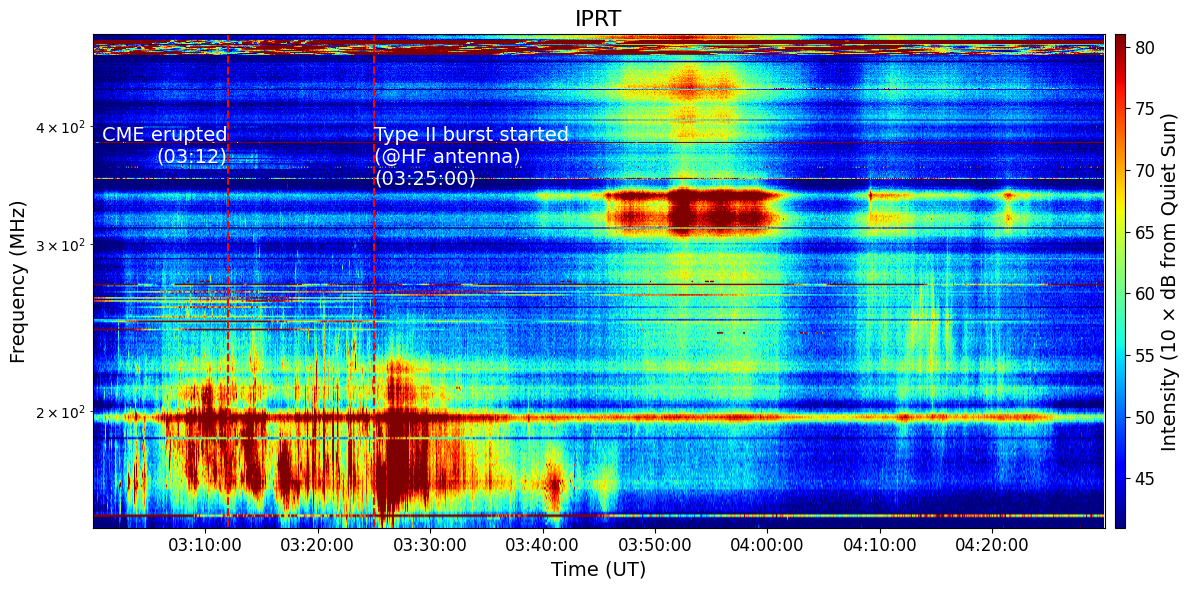

In [38]:
# **強度範囲 (-10 〜 50 dB) を設定**
plot_dynamic_spectrum(fits_file,
                      start_time=pd.Timestamp("2022-06-13T03:00:00"),
                      end_time=pd.Timestamp("2022-06-13T04:30:00"), 
                      min_frequency=150,
                      max_frequency=500, 
                      xticks_interval=10*60,
                      yticks_interval=50
                      )

データの shape: (2, 410, 42120)
時間範囲: 2022-06-13 03:00:00 〜 2022-06-13 05:00:00
周波数範囲: 150 〜 499.413858
time_axis のデータ数: 42120
freq_axis のデータ数: 410
time_mask の True の数: 7164 / 42120
freq_mask の True の数: 358 / 410
画像を保存しました: /home/kinno-7010/Research/IPRT/IPRT_image_plot/RH_20220613_030000_20220613_050000_150-499.413858MHz.png


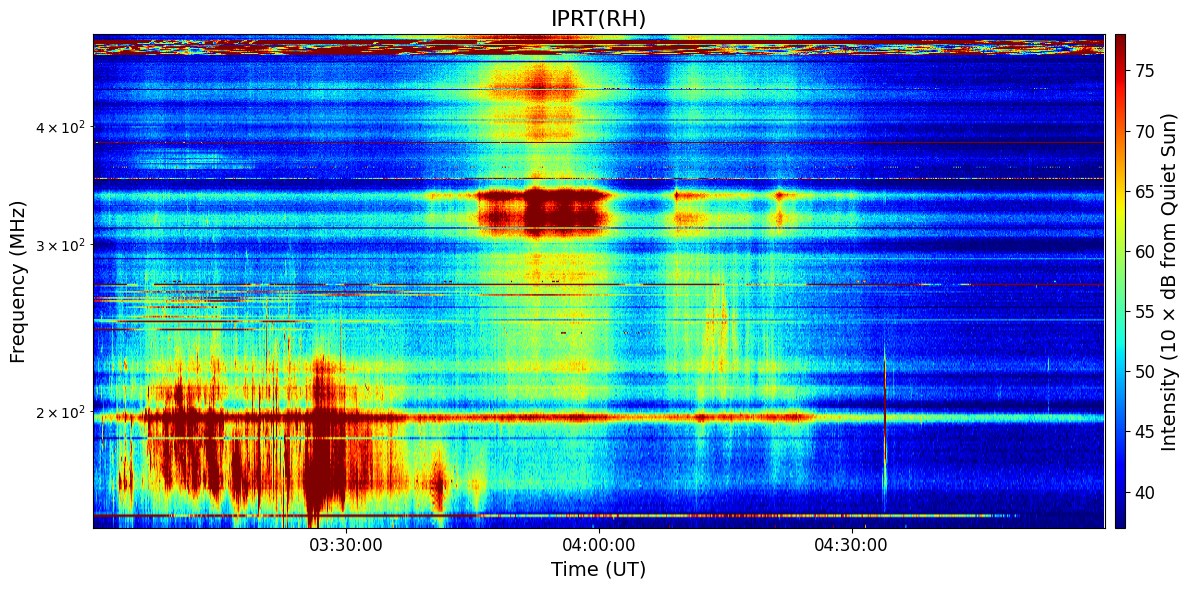

データの shape: (2, 410, 42120)
時間範囲: 2022-06-13 03:00:00 〜 2022-06-13 05:00:00
周波数範囲: 150 〜 499.413858
time_axis のデータ数: 42120
freq_axis のデータ数: 410
time_mask の True の数: 7164 / 42120
freq_mask の True の数: 358 / 410
画像を保存しました: /home/kinno-7010/Research/IPRT/IPRT_image_plot/LH_20220613_030000_20220613_050000_150-499.413858MHz.png


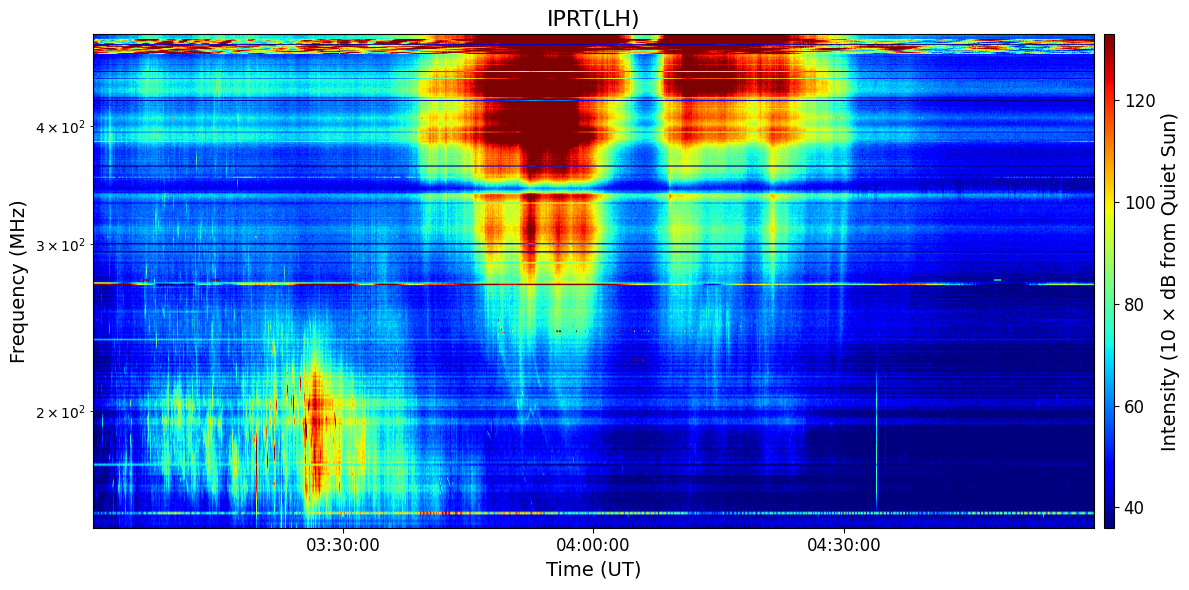

In [7]:
# **強度範囲 (-10 〜 50 dB) を設定**
plot_rh_dynamic_spectrum(fits_file,
                      start_time=pd.Timestamp("2022-06-13T03:00:00"),
                      end_time=pd.Timestamp("2022-06-13T05:00:00"), 
                      min_frequency=150,
                      max_frequency=500, 
                      vmin=None,
                      vmax=None,
                      xticks_interval=30*60,
                      yticks_interval=50
                      )

plot_lh_dynamic_spectrum(fits_file,
                      start_time=pd.Timestamp("2022-06-13T03:00:00"),
                      end_time=pd.Timestamp("2022-06-13T05:00:00"), 
                      min_frequency=150,
                      max_frequency=500, 
                      vmin=None,
                      vmax=None,
                      xticks_interval=30*60,
                      yticks_interval=50
                      )

データの shape: (2, 410, 42120)
時間範囲: 2022-06-13 03:05:00 〜 2022-06-13 03:25:00
周波数範囲: 150 〜 200
time_axis のデータ数: 42120
freq_axis のデータ数: 410
time_mask の True の数: 1194 / 42120
freq_mask の True の数: 51 / 410
画像を保存しました: /home/kinno-7010/Research/IPRT/IPRT_image_plot/20220613_030500_20220613_032500_150-200MHz.png


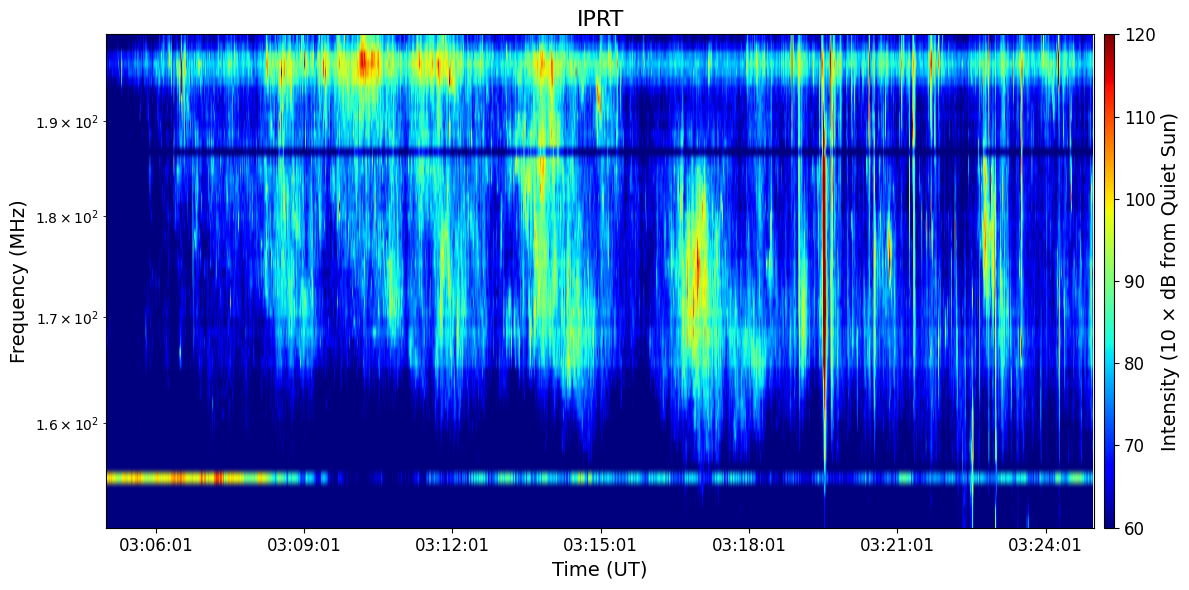

In [53]:
# **強度範囲 (-10 〜 50 dB) を設定**
plot_dynamic_spectrum(fits_file,
                      start_time=pd.Timestamp("2022-06-13T03:05:00"),
                      end_time=pd.Timestamp("2022-06-13T03:25:00"), 
                      min_frequency=150,
                      max_frequency=200, 
                      xticks_interval=3*60,
                      yticks_interval=50,
                      vmin=60,
                      vmax=120
                      )

データの shape: (2, 410, 42120)
時間範囲: 2022-06-13 03:40:00 〜 2022-06-13 03:50:00
周波数範囲: 150 〜 180
time_axis のデータ数: 42120
freq_axis のデータ数: 410
time_mask の True の数: 597 / 42120
freq_mask の True の数: 30 / 410
画像を保存しました: /home/kinno-7010/Research/IPRT/IPRT_image_plot/20220613_034000_20220613_035000_150-180MHz.png


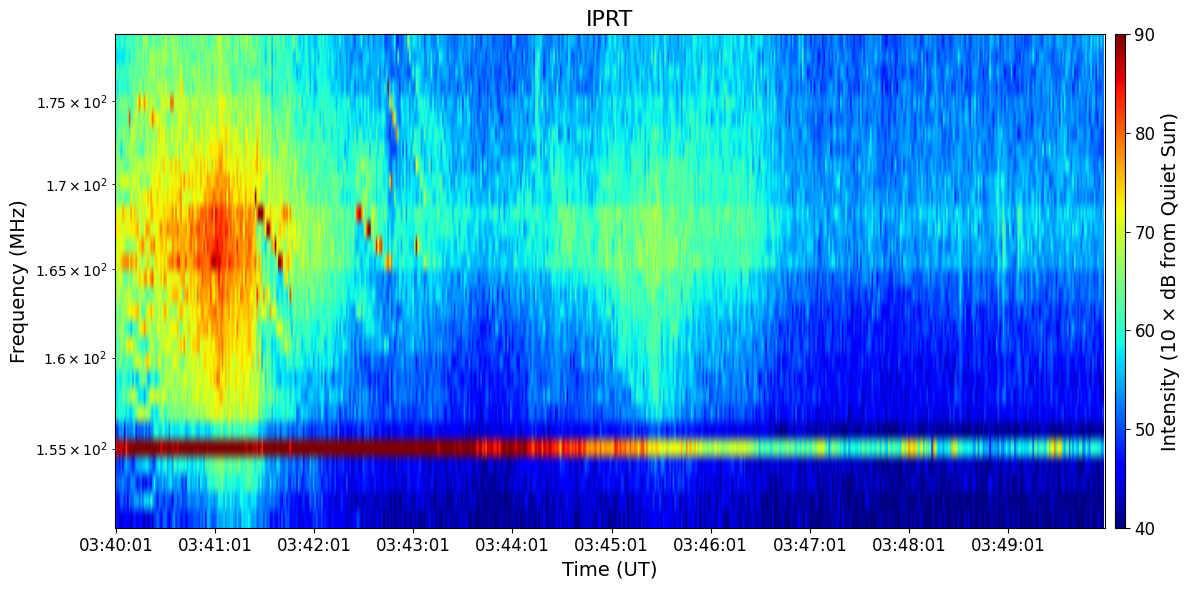

In [9]:
# **強度範囲 (-10 〜 50 dB) を設定**
plot_dynamic_spectrum(fits_file,
                      start_time=pd.Timestamp("2022-06-13T03:40:00"),
                      end_time=pd.Timestamp("2022-06-13T03:50:00"), 
                      min_frequency=150,
                      max_frequency=180,
                      xticks_interval=1*60,
                      yticks_interval=10,
                      vmin=40,
                      vmax=90
                      )

## test

In [6]:
import pandas as pd
from astropy.io import fits

# FITSファイルのパス
# fits_file = "/home/kinno-7010/Research/FITS file/IPRT/20220613_IPRT.fits"

# FITSファイルを開く
with fits.open(fits_file) as hdul:
    header = hdul[0].header  # ヘッダー情報を取得

# 時間範囲の取得
start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
end_time = pd.Timestamp(f"{header['DATE-END']} {header['TIME-END']}")

# 出力
print(f"データの開始時間: {start_time}")
print(f"データの終了時間: {end_time}")


データの開始時間: 2022-06-12 20:50:09
データの終了時間: 2022-06-13 08:35:44


In [7]:
import numpy as np
import pandas as pd
from astropy.io import fits

# FITSファイルのパス
# fits_file = "/home/kinno-7010/Research/FITS file/IPRT/20220613_IPRT.fits"

# FITSファイルを開く
with fits.open(fits_file) as hdul:
    data = hdul[0].data  # データ部分を取得
    header = hdul[0].header  # ヘッダー情報を取得

# 時間軸の作成
start_time = pd.Timestamp("2022-06-12 20:50:09")
end_time = pd.Timestamp("2022-06-13 08:35:44")
time_axis = pd.date_range(start=start_time, end=end_time, periods=data.shape[0])

# 周波数軸の作成
freq_start = header['CRVAL2']  # 開始周波数 (MHz)
freq_step = header['CDELT2']   # 周波数間隔 (MHz)
num_freqs = header['NAXIS2']   # 周波数データの数

freq_axis = np.linspace(freq_start, freq_start + freq_step * (num_freqs - 1), num_freqs)

# 強度データの取得（RCPのみ）
intensity_data = data[:, :, 0]  # 2次元データ [時間, 周波数]

# データの表示
print("時間のデータリスト:")
print(time_axis)

print("\n周波数のデータリスト:")
print(freq_axis)

print("\n強度のデータリスト:")
print(intensity_data)


時間のデータリスト:
DatetimeIndex(['2022-06-12 20:50:09', '2022-06-13 08:35:44'], dtype='datetime64[ns]', freq=None)

周波数のデータリスト:
[100.       100.976562 101.953124 102.929686 103.906248 104.88281
 105.859372 106.835934 107.812496 108.789058 109.76562  110.742182
 111.718744 112.695306 113.671868 114.64843  115.624992 116.601554
 117.578116 118.554678 119.53124  120.507802 121.484364 122.460926
 123.437488 124.41405  125.390612 126.367174 127.343736 128.320298
 129.29686  130.273422 131.249984 132.226546 133.203108 134.17967
 135.156232 136.132794 137.109356 138.085918 139.06248  140.039042
 141.015604 141.992166 142.968728 143.94529  144.921852 145.898414
 146.874976 147.851538 148.8281   149.804662 150.781224 151.757786
 152.734348 153.71091  154.687472 155.664034 156.640596 157.617158
 158.59372  159.570282 160.546844 161.523406 162.499968 163.47653
 164.453092 165.429654 166.406216 167.382778 168.35934  169.335902
 170.312464 171.289026 172.265588 173.24215  174.218712 175.195274
 176.171836

In [8]:
import numpy as np
import pandas as pd
from astropy.io import fits

# FITSファイルのパス
# fits_file = "/home/kinno-7010/Research/FITS file/IPRT/20220613_IPRT.fits"

# FITSファイルを開く
with fits.open(fits_file) as hdul:
    data = hdul[0].data  # データ部分を取得
    header = hdul[0].header  # ヘッダー情報を取得

# 時間軸の作成（全時間データを取得）
start_time = pd.Timestamp("2022-06-12 20:50:09")
end_time = pd.Timestamp("2022-06-13 08:35:44")
time_axis = pd.date_range(start=start_time, end=end_time, periods=data.shape[0])

# **全ての時間データを表示**
for t in time_axis:
    print(t)


2022-06-12 20:50:09
2022-06-13 08:35:44


## memo

In [9]:
from astropy.io import fits

# fits_file_path = "/home/kinno-7010/Research/FITS file/IPRT/20220613_IPRT.fits"

with fits.open(fits_file_path) as hdul:
    header = hdul[0].header

    # 周波数軸の情報を取得
    freq_keys = ["CTYPE2", "CRPIX2", "CRVAL2", "CDELT2", "CUNIT2"]
    for key in freq_keys:
        if key in header:
            print(f"{key}: {header[key]}")
        else:
            print(f"{key} is not found in header")


NameError: name 'fits_file_path' is not defined

In [9]:
from astropy.io import fits

# FITSファイルのパス
# fits_file = "/home/kinno-7010/Research/FITS file/IPRT/20220613_IPRT.fits"

# FITSファイルを開く
with fits.open(fits_file) as hdul:
    header = hdul[0].header  # ヘッダー情報を取得

# **全てのヘッダー情報を表示**
print(repr(header))


SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                    8 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                42120 /                                                
NAXIS2  =                  410 /frequency                                       
NAXIS3  =                    2 /Polarization. 0 is RCP and 1 is LCP             
EXTEND  =                    F /File contains no extensions                     
DATE    = '2022-06-13'         /                                                
CONTENT = '2022-06-13       -4:50:09 AMATERAS LCP and RCP' /Title of image      
ORIGIN  = 'PPARC TOHOKU University' /Organization name                          
TELESCOP= 'IPRT    '           /Telescope name                                  
INSTRUME= 'AMATERAS'           /Name of the spectrometer                        
OBJECT  = 'Sun     '        

## LH

データの shape: (2, 410, 42120)
時間範囲: 2022-06-13 03:00:00 〜 2022-06-13 04:30:00
周波数範囲: 100 〜 499.413858
time_axis のデータ数: 42120
freq_axis のデータ数: 410
time_mask の True の数: 5373 / 42120
freq_mask の True の数: 410 / 410
画像を保存しました: /home/kinno-7010/Research/IPRT/IPRT_image_plot/LH_20220613_030000_20220613_043000_100-499.413858MHz.png


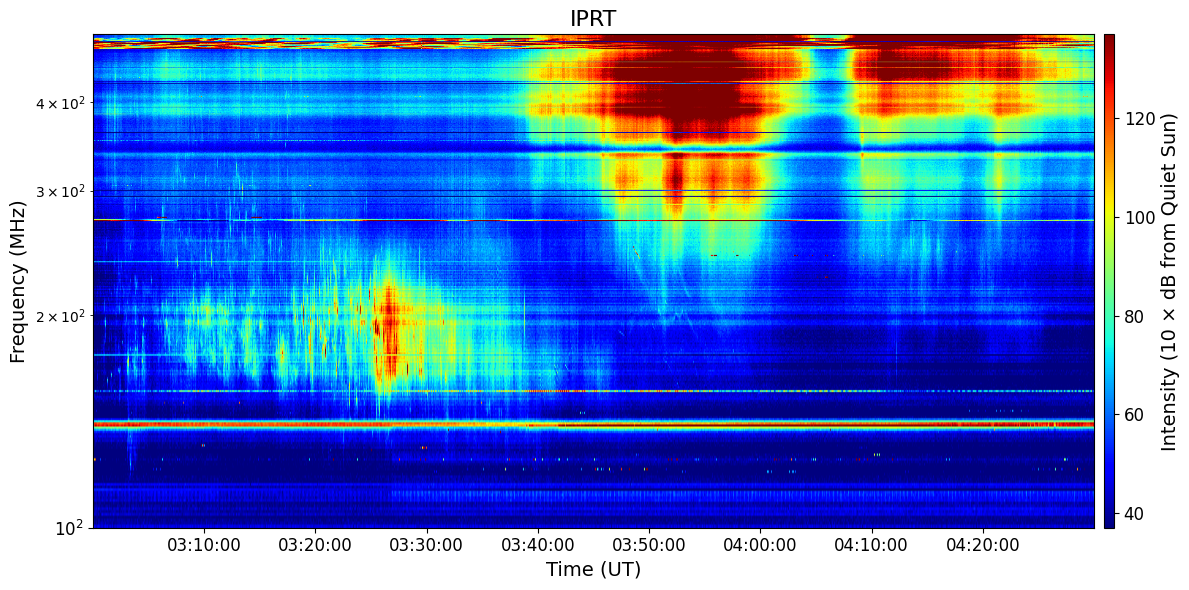

In [6]:
def load_fits_data(fits_file):
    """FITSファイルを読み込んで、データとヘッダーを取得する"""
    with fits.open(fits_file) as hdul:
        data = hdul[0].data  # データ部分を取得
        header = hdul[0].header  # ヘッダー情報を取得
    return data, header

def generate_time_axis(header):
    """FITSのヘッダー情報から時間軸を作成する"""
    start_time = pd.Timestamp(f"{header['DATE-OBS']} {header['TIME-OBS']}")
    end_time = pd.Timestamp(f"{header['DATE-END']} {header['TIME-END']}")
    num_points = header['NAXIS1']
    return pd.date_range(start=start_time, end=end_time, periods=num_points)

def generate_frequency_axis(header):
    """FITSのヘッダー情報から周波数軸を作成する"""
    freq_start = header['CRVAL2']
    freq_step = header['CDELT2']
    num_freqs = header['NAXIS2']
    return np.linspace(freq_start, freq_start + freq_step * (num_freqs - 1), num_freqs)

def plot_dynamic_spectrum(fits_file, start_time, end_time, min_frequency, max_frequency, 
                          xticks_interval, yticks_interval, vmin, vmax):
    """ダイナミックスペクトルをプロットして画像を保存する関数"""
    # FITSデータの読み込み
    data, header = load_fits_data(fits_file)

    # データの形状を確認
    print(f"データの shape: {data.shape}")

    # 時間軸と周波数軸の生成
    time_axis = generate_time_axis(header)
    freq_axis = generate_frequency_axis(header)

    # 時間範囲の制限
    if start_time < time_axis[0]:
        start_time = time_axis[0]
    if end_time > time_axis[-1]:
        end_time = time_axis[-1]

    # 周波数範囲の制限
    if min_frequency < freq_axis[0]:
        min_frequency = freq_axis[0]
    if max_frequency > freq_axis[-1]:
        max_frequency = freq_axis[-1]

    # 修正: ミリ秒単位の誤差を補正
    time_mask = (time_axis >= start_time.floor('s')) & (time_axis <= end_time.ceil('s'))
    freq_mask = (freq_axis >= min_frequency) & (freq_axis <= max_frequency)
    
    # 現在の範囲を確認
    print(f"時間範囲: {start_time} 〜 {end_time}")
    print(f"周波数範囲: {min_frequency} 〜 {max_frequency}")
    print(f"time_axis のデータ数: {len(time_mask)}")
    print(f"freq_axis のデータ数: {len(freq_mask)}")

    # 確認
    print(f"time_mask の True の数: {np.sum(time_mask)} / {len(time_mask)}")
    print(f"freq_mask の True の数: {np.sum(freq_mask)} / {len(freq_mask)}")

    # 修正: データのインデックス適用
    # ここでは、data の形状が (1, num_freq, num_time) であることを想定
    trimmed_data = data[1, freq_mask, :][:, time_mask]
    trimmed_time_axis = time_axis[time_mask]
    trimmed_freq_axis = freq_axis[freq_mask]

    # データが空の場合のエラー処理
    if trimmed_data.size == 0:
        print("指定した時間・周波数範囲にデータがありません。範囲を調整してください。")
        return

    # プロットの作成
    fig, ax = plt.subplots(figsize=(12, 6))

    # カラーバーの追加
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)

    # カラープロット用の extent 設定
    extent = [
        mdates.date2num(trimmed_time_axis[0]),  
        mdates.date2num(trimmed_time_axis[-1]),
        trimmed_freq_axis[0],
        trimmed_freq_axis[-1]
    ]
    
    if vmin is None:
        vmin = np.percentile(trimmed_data, 5)
    if vmax is None:
        vmax = np.percentile(trimmed_data, 95)
    
    img = ax.imshow(trimmed_data, aspect='auto', origin='lower', extent=extent, cmap='jet', vmin=vmin, vmax=vmax)

    # カラーバーの設定
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Intensity (10 × dB from Quiet Sun)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    
    # # 垂直線とテキスト
    # # 垂直線とテキストの表示
    # ax.vlines(pd.Timestamp('2022-06-13 03:12:00'), min_frequency+1, max_frequency, color='red', linestyle='--')
    # ax.text(pd.Timestamp('2022-06-13 03:12:00'), 400, 'CME erupted\n(03:12)', color='white', fontsize=14, ha='right', va='top')
    # ax.vlines(pd.Timestamp('2022-06-13 03:25:00'), min_frequency+1, max_frequency, color='red', linestyle='--')
    # ax.text(pd.Timestamp('2022-06-13 03:25:00'), 400, 'Type II burst started \n(@HF antenna)\n(03:25:00)', color='white', fontsize=14, ha='left', va='top')

    # 軸ラベルとタイトル
    ax.set_xlabel('Time (UT)', fontsize=14)
    ax.set_ylabel('Frequency (MHz)', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title('IPRT', fontsize=16)

    # 時間軸のフォーマットを UT 時間に設定
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim(mdates.date2num(trimmed_time_axis[0]), mdates.date2num(trimmed_time_axis[-1]))

    # X軸の目盛りを調整
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=xticks_interval))

    # Y軸の目盛りの間隔を変更
    ax.yaxis.set_major_locator(mticker.MultipleLocator(yticks_interval))
    ax.set_yscale('log')
    
    # 画像の保存用フォルダ設定
    output_folder = "/home/kinno-7010/Research/IPRT/IPRT_image_plot"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # フォルダがなければ作成

    # ファイル名を適切なフォーマットに変換
    start_str = start_time.strftime("%Y%m%d_%H%M%S")
    end_str = end_time.strftime("%Y%m%d_%H%M%S")
    output_filename = os.path.join(output_folder, f"LH_{start_str}_{end_str}_{min_frequency}-{max_frequency}MHz.png")

    plt.savefig(output_filename, dpi=300)  # 高解像度で保存
    print(f"画像を保存しました: {output_filename}")

    # レイアウト調整と表示
    plt.tight_layout()
    plt.show()
    
    
# **強度範囲 (-10 〜 50 dB) を設定**
plot_dynamic_spectrum(fits_file,
                      start_time=pd.Timestamp("2022-06-13T03:00:00"),
                      end_time=pd.Timestamp("2022-06-13T04:30:00"), 
                      min_frequency=100,
                      max_frequency=500, 
                      xticks_interval=10*60,
                      yticks_interval=50,
                      vmin=None, vmax=None
                      )